# Downloads

In [1]:
!gdown 'https://docs.google.com/uc?export=download&id=1QDPNVVFwpXD6XhFJMTmxjQZ64Fntmvp_' #Fetch the dataset
!unzip imdb-reviews.csv.zip

Downloading...
From: https://docs.google.com/uc?export=download&id=1QDPNVVFwpXD6XhFJMTmxjQZ64Fntmvp_
To: /content/imdb-reviews.csv.zip
100% 24.6M/24.6M [00:00<00:00, 36.8MB/s]
Archive:  imdb-reviews.csv.zip
  inflating: imdb-reviews.csv        


In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2024-10-13 07:17:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-10-13 07:17:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-10-13 07:17:06--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [3]:
!pip3 install -U torchtext==0.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.2 MB/s eta 0:00:00


# Imports

In [4]:
import copy                        as cp
import torch
import numpy                       as np
import pandas                      as pd
import seaborn                     as sns
import torch.nn                    as nn
import matplotlib.pyplot           as plt

from sklearn                       import metrics
from gensim.models                 import KeyedVectors
from sklearn.metrics               import f1_score
from sklearn.metrics               import roc_curve
from torchtext.data.utils          import get_tokenizer
from sklearn.model_selection       import train_test_split
from gensim.scripts.glove2word2vec import glove2word2vec

# Data preprocessing

## Booleanize the ratings

In [5]:
df        = pd.read_csv('imdb-reviews.csv',sep='\t')
df.rating = df.rating.replace([0,1,2,3,4],0)      #0 for the negative reviews
df.rating = df.rating.replace([6,7,8,9,10],1)     #1 for the positive reviews

df.head(5)

,url,rating,review
0,http://www.imdb.com/title/tt0120623/usercomments,1.0,I thought this was a quiet good movie. It was ...
1,http://www.imdb.com/title/tt0043117/usercomments,1.0,Wagon Master is a very unique film amongst Joh...
2,http://www.imdb.com/title/tt0043117/usercomments,1.0,This film has to be as near to perfect a film ...
3,http://www.imdb.com/title/tt0835204/usercomments,0.0,I gave this 4 stars because it has a lot of in...
4,http://www.imdb.com/title/tt0499603/usercomments,1.0,This movie is really genuine and random. It's ...


## Transform from Glove to Word2Vec

In [6]:
glove_input_file = 'glove.6B.300d.txt' #Get the 300d vectors for each word.
w2v_output_file  = 'glv_with_w2v_format.txt'

glove = KeyedVectors.load_word2vec_format(glove_input_file, binary=False, no_header=True)

## Tokenizing the reviews

In [7]:
def tokenize_reviews(reviews):
    tokenized_reviews = []

    tokenizer         = get_tokenizer("basic_english")

    for review in reviews:
        tokenized_reviews.append(tokenizer(review)) #Split each review into single words.

    return tokenized_reviews

tokenized_reviews     = tokenize_reviews(df.review)

## Vectorize using Word2Vec(-GloVe)

In [9]:
def vectorize_reviews(tokenized_reviews):
    review_vectors = []

    for text in tokenized_reviews:
        vec_text   = []

        for word in text:
            if word in glove.key_to_index:
                vec_text.append(torch.Tensor(glove.get_vector(word)))                   #Find the glove vector of each word.
        vect = torch.stack(vec_text)                                                    #Store the result for each word.
        review_vectors.append(torch.sum((vect-torch.mean(vect))/torch.std(vect),dim=0)) #Normalize the data for the review.

    return review_vectors

#https://github.com/pytorch/pytorch/issues/47160                                         Concering probable warning.

review_vectors     = vectorize_reviews(tokenized_reviews)

## Create X and Y

In [50]:
x = torch.stack(review_vectors) #Turn the list to torch tensor.
y = torch.Tensor(df.rating)     #Turn the list of ratings to torch tensor.
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)
                                #Split to train and test.

# Neural Network

In [157]:
_ = torch.manual_seed(42)

## Neural Network 1

In [158]:
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, H5, D_out):
        super(Net, self).__init__()

        self.linear1  = nn.Linear(D_in, H1)
        self.linear2  = nn.Linear(H1, H2)
        self.linear3  = nn.Linear(H2, H3)
        self.linear4  = nn.Linear(H3, H4)
        self.linear5  = nn.Linear(H4, H5)
        self.linear6  = nn.Linear(H5, D_out)
        self.sig      = nn.Sigmoid()

    def forward(self, x):
        h1  = self.linear1(x)
        h2  = self.linear2(h1)
        h3  = self.linear3(h2)
        h4  = self.linear4(h3)
        h5  = self.linear5(h4)
        out = self.sig(self.linear6(h5))

        return out

### Define the parameters

In [159]:
#Define layer sizes
D_in  = x_train.shape[1]
H1    = 250
H2    = 200
H3    = 150
H4    = 100
H5    = 50
D_out = 1

#Define Hyperparameters
learning_rate_NAdam = 1e-5
learning_rate_AdamW = 1e-6
#Initialise model, loss, optimizer
model_NAdam         = Net(D_in, H1, H2, H3, H4, H5, D_out)
model_AdamW         = Net(D_in, H1, H2, H3, H4, H5, D_out)
loss_func           = nn.MSELoss()
optimizer_NAdam     = torch.optim.NAdam(model_NAdam.parameters(), lr=learning_rate_NAdam, weight_decay=1e-6)
optimizer_AdamW     = torch.optim.AdamW(model_AdamW.parameters(), lr=learning_rate_AdamW, weight_decay=1e-6)
#Initialise dataloader
dataset             = torch.utils.data.TensorDataset(x_train, y_train)
dataloader          = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

### Training the neural network

In [160]:
def train_net(model,optimizer,epochs,dataloader,val_err,train_err,choice=-1):
    for epoch in range(epochs):
        batch_loss = []

        for x, y in dataloader:
            y_pred = model(x).flatten()

            loss   = loss_func(y_pred, y)
            batch_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # training data
        with torch.no_grad():
            model.eval()

            y_train_pred = model(x_train).flatten()
            train_loss = loss_func(y_train_pred, y_train)

            # test data
            y_test_pred = model(x_test)
            y_test_pred = y_test_pred.flatten()
            val_loss = loss_func(y_test_pred, y_test)
            if choice == -1:
                val_err.append(val_loss.item())
            else:
                val_err[choice].append(val_loss.item())

            model.train()

        if choice == -1:
            train_err.append(sum(batch_loss)/len(dataloader))
        else:
            train_err[choice].append(sum(batch_loss)/len(dataloader))

        print(f'Epoch: {(epoch + 1):3}\n')
        if choice == -1:
            print(f'Train loss = {train_err[-1]}')
            print(f'Test  loss = {val_err[-1]}')
        else:
            print(f'Train loss = {train_err[choice][-1]}')
            print(f'Test  loss = {val_err[choice][-1]}')
        print('---')


In [161]:
n_adam         = 0
adam_w         = 1
epochs         = 100
val_err        = [[],[]]
train_err      = [[],[]]

print('## Training NAdam ##')
train_net(model_NAdam,optimizer_NAdam,epochs,dataloader,val_err,train_err,n_adam)
print('\n## Training AdamW ##')
train_net(model_AdamW,optimizer_AdamW,epochs,dataloader,val_err,train_err,adam_w)

## Training NAdam ##
Epoch:   1

Train loss = 0.18733488831199296
Test  loss = 0.1586846560239792
---
Epoch:   2

Train loss = 0.14455118186467494
Test  loss = 0.1408025622367859
---
Epoch:   3

Train loss = 0.133884446301744
Test  loss = 0.13310344517230988
---
Epoch:   4

Train loss = 0.12894925569741594
Test  loss = 0.12829384207725525
---
Epoch:   5

Train loss = 0.12614935123383153
Test  loss = 0.12467536330223083
---
Epoch:   6

Train loss = 0.12434904066412371
Test  loss = 0.12207534164190292
---
Epoch:   7

Train loss = 0.12306492867983786
Test  loss = 0.12015832960605621
---
Epoch:   8

Train loss = 0.12206515747901601
Test  loss = 0.11877844482660294
---
Epoch:   9

Train loss = 0.12126965959743327
Test  loss = 0.11776084452867508
---
Epoch:  10

Train loss = 0.1206371161961005
Test  loss = 0.11695577949285507
---
Epoch:  11

Train loss = 0.12012628108911468
Test  loss = 0.11626467853784561
---
Epoch:  12

Train loss = 0.1197032507353497
Test  loss = 0.11564892530441284
---
E

### Evaluating the neural network

#### Learning Curve

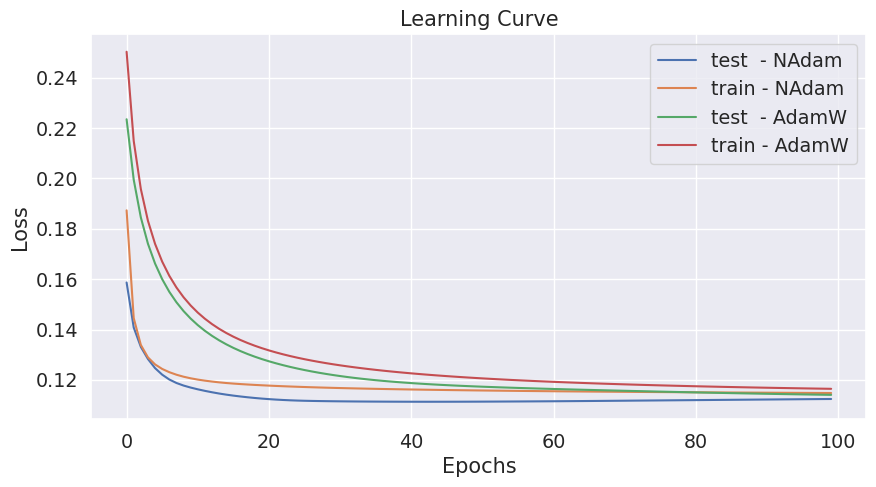

In [162]:
fig = plt.figure(figsize=(10,5))
_   = plt.grid(which='major', linestyle='-')
_   = plt.title('Learning Curve')
_   = plt.plot(  val_err[0],label='test  - NAdam')
_   = plt.plot(train_err[0],label='train - NAdam')
_   = plt.plot(  val_err[1],label='test  - AdamW')
_   = plt.plot(train_err[1],label='train - AdamW')
_   = plt.ylabel('Loss')
_   = plt.xlabel('Epochs')
_   = plt.legend()
_   = plt.show()

#### Accuracy, Precision, Recall, F1-Measure

In [163]:
def test_model_output(model,x_test):
    y_pred = torch.round(model(x_test))
    y_pred[y_pred < 0] = +0.0
    y_pred[y_pred > 1] = 1 #Turn to bool.

    return y_pred.flatten().detach().numpy()

y_pred = test_model_output(model_NAdam,x_test)

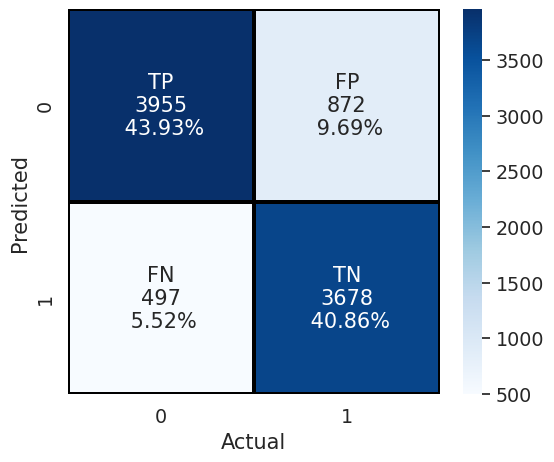

In [164]:
def confusion_matrix(y_test,y_pred):
    cm_values = metrics.confusion_matrix(y_test,y_pred)
    np.fill_diagonal(cm_values,cp.deepcopy(np.flip(cm_values.diagonal())))
                        #The output is [[tn, fp], [fn, tp]],
                        #but we need [[tp, fp], [fn, tn]],
                        #so we reverse the diagonal.

    names   = ['TP','FP','FN','TN']
    counts  = ['{0:0.0f}'.format(value) for value in cm_values.flatten()]
    percent = [' {0:.2%}'.format(value) for value in cm_values.flatten()/np.sum(cm_values)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(names,counts,percent)]
    labels = np.asarray(labels).reshape(2,2)

    fig, ax = plt.subplots(figsize=(6,5))
    sns.set(font_scale=1.25)

    r = sns.heatmap(cm_values,fmt='', linecolor='black',annot=labels,cmap='Blues',linewidths=1.5)

    _ = r.set(xlabel='Actual',ylabel='Predicted')

    return counts

counts = confusion_matrix(y_test,y_pred)

In [165]:
def confusion_metrics(counts):
    tp = int(counts[0])
    fp = int(counts[1])
    fn = int(counts[2])
    tn = int(counts[3])

    print("Recall    = ", tp / (tp + fn))
    print("Precision = ", tp / (tp + fp))
    print("Accuracy  = ",(tp + tn) / (tp + tn + fp + fn))
    print("F1-score  = ",(2 * tp)  / ( 2 * tp + fp + fn))

confusion_metrics(counts)

Recall    =  0.8883647798742138
Precision =  0.8193494924383675
Accuracy  =  0.8479226838480338
F1-score  =  0.8524625498437332


#### ROC Curve

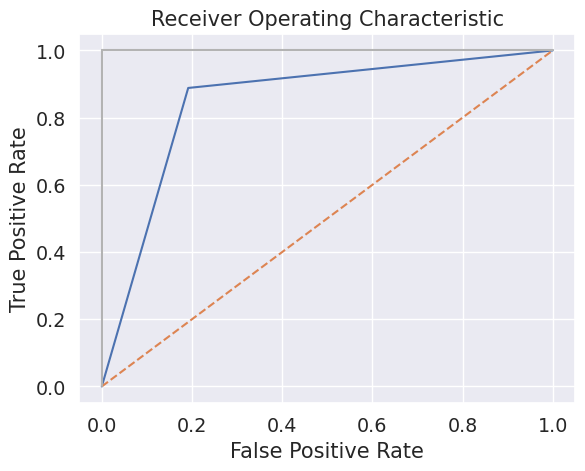

In [166]:
def Roc_Curve(y_test,y_pred):
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_pred)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate1, true_positive_rate1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7")
    plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Roc_Curve(y_test,y_pred)

## Neural Network 2

In [137]:
from scipy.special import hyp1f1
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(Net, self).__init__()

        self.linear1  = nn.Linear(D_in, H1)
        self.linear2  = nn.Linear(H1,   H2)
        self.linear3  = nn.Linear(H2,   H3)
        self.linear4  = nn.Linear(H3,   H4)
        self.linear5  = nn.Linear(H4,  D_out)
        self.sig      = nn.Sigmoid()

    def forward(self, x):
        h1  = self.linear1(x)
        h2  = self.linear2(h1)
        h3  = self.linear3(h2)
        h4  = self.linear4(h3)
        out = self.sig(self.linear5(h4))

        return out

### Define the parameters

In [138]:
#Define layer sizes
D_in  = x_train.shape[1]
H1    = 200
H2    = 100
H3    = 50
H4    = 10
D_out = 1

#Define Hyperparameters
learning_rate = 1e-4
#Initialise model, loss, optimizer
model_SGD     = Net(D_in, H1, H2, H3, H4, D_out)
loss_func     = nn.MSELoss()
optimizer     = torch.optim.SGD(model_SGD.parameters(), lr=learning_rate)
#Initialise dataloader
dataset       = torch.utils.data.TensorDataset(x_train, y_train)
dataloader    = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

### Training the neural network

In [139]:
epochs         = 100
val_err        = []
train_err      = []

print('\n## Training SGD ##')
train_net(model_SGD,optimizer,epochs,dataloader,val_err,train_err)


## Training SGD ##
Epoch:   1

Train loss = 0.25679267016545493
Test  loss = 0.23258058726787567
---
Epoch:   2

Train loss = 0.2239934682687265
Test  loss = 0.20685884356498718
---
Epoch:   3

Train loss = 0.2051886771648434
Test  loss = 0.1920870840549469
---
Epoch:   4

Train loss = 0.19313402188078335
Test  loss = 0.18208563327789307
---
Epoch:   5

Train loss = 0.1844373211052871
Test  loss = 0.17462599277496338
---
Epoch:   6

Train loss = 0.17769826833509425
Test  loss = 0.1687084138393402
---
Epoch:   7

Train loss = 0.17227062244186606
Test  loss = 0.16382116079330444
---
Epoch:   8

Train loss = 0.1677823512025879
Test  loss = 0.15967456996440887
---
Epoch:   9

Train loss = 0.16398722317142556
Test  loss = 0.15609122812747955
---
Epoch:  10

Train loss = 0.1607184414991689
Test  loss = 0.15295423567295074
---
Epoch:  11

Train loss = 0.15786340988868083
Test  loss = 0.15018141269683838
---
Epoch:  12

Train loss = 0.1553430184060261
Test  loss = 0.14771167933940887
---
Epoc

### Evaluating the neural network

#### Learning Curve

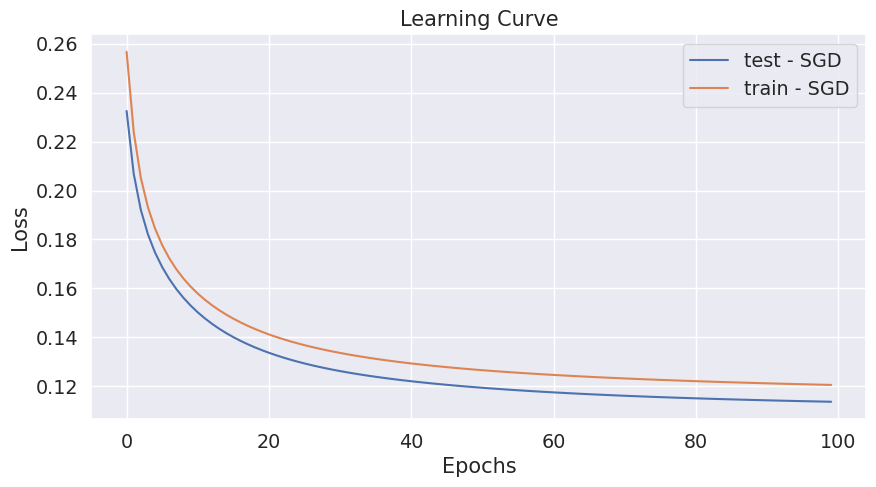

In [141]:
fig = plt.figure(figsize=(10,5))
plt.grid(which='major', linestyle='-')
plt.title('Learning Curve')
plt.plot(val_err,  label='test - SGD')
plt.plot(train_err,label='train - SGD')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

#### Accuracy, Precision, Recall, F1-Measure

In [142]:
y_pred = test_model_output(model_SGD,x_test)

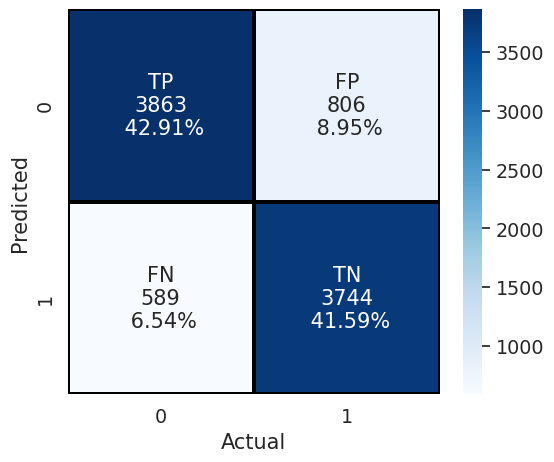

In [143]:
counts = confusion_matrix(y_test,y_pred)

In [144]:
confusion_metrics(counts)

Recall    =  0.8676999101527404
Precision =  0.8273720282715785
Accuracy  =  0.845034436791824
F1-score  =  0.847056243832913


#### ROC Curve

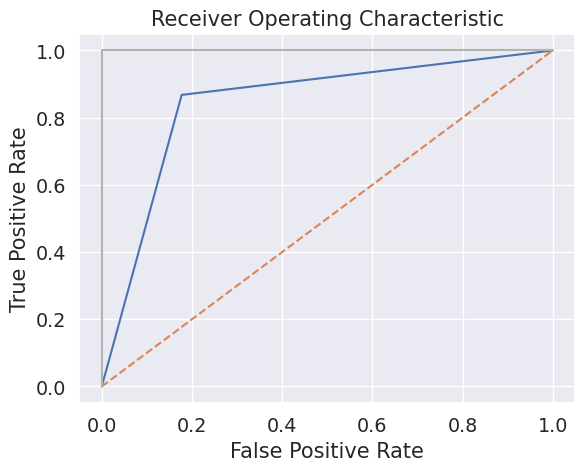

In [145]:
Roc_Curve(y_test,y_pred)